# Sparse Deconvolution

Deconvolution seeks to recover the input signal $\mathbf{x}^{\star}$ from 
the available output signal $\mathbf{y}$ of a linear time invariant system   
with finite impulse response (FIR) $\mathbf{h}$.  

In this example the FIR is created using the randomized image method (RIM), 
a popular method used to simulate acoustic impulse responses.


In [1]:
using RIM

srand(123)

Fs = 4000        # sampling frequency
SNR = 15         # signal to noise ratio 
env = AcEnv(Fs)

Lx,Ly,Lz = 4.,5.,3. # room dimensions
T60 = 0.3           # reverberation time
geo = CuboidRoom(Lx,Ly,Lz,T60,env) #geometry definition

xs = [0.5 0.5 0.5]'            # src pos (in meters)
xr = [Lx-0.1 Ly-0.3 Lz-0.2]'   # mic pos
Nh = div(Fs,4)                 # IR samples 
Nx = div(Fs,2)                 # x  samples 

t = linspace(0,1/Fs*Nx,Nx)
h = rim(xs,xr,Nh,geo,env)[:]; # Impuse Response


The available signal $\mathbf{y}$ results from 
the convolution between $\mathbf{h}$ and $\mathbf{x}$.

A signal $\mathbf{y}$ can be generated by using a ground truth signal `x_gt` 
and add noise to it to simulate sensor noise.

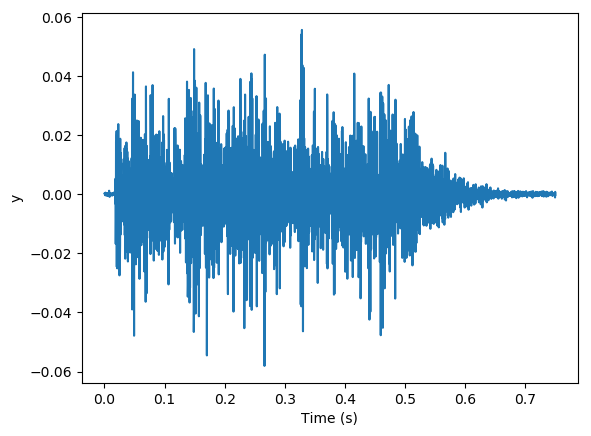

In [2]:
x_gt = full(sprandn(Nx, 0.05))  # sparse signal ground truth input 

y0 = conv(x_gt,h)                                    # output signal
y = y0+10^(-SNR/10)*sqrt(var(y0))*randn(length(y0)); # add noise

using PyPlot

figure()
plot(linspace(0,1/Fs*length(y),length(y)),y)
xlabel("Time (s)")
ylabel("y");

A classical way of reconstructing $\mathbf{x}$ is by the least squares procedure:

$$ \mathbf{x}_{ls} =  \underset{\mathbf{x}}{\text{argmin}} \tfrac{1}{2} \| \mathbf{A} \mathbf{x} -\mathbf{y} \|^2,  $$

where $\mathbf{A}$ is the Toeplitz matrix that models convolution. 

The least squares problem has analytic solution and can be solved by means of a pseudo inverse.


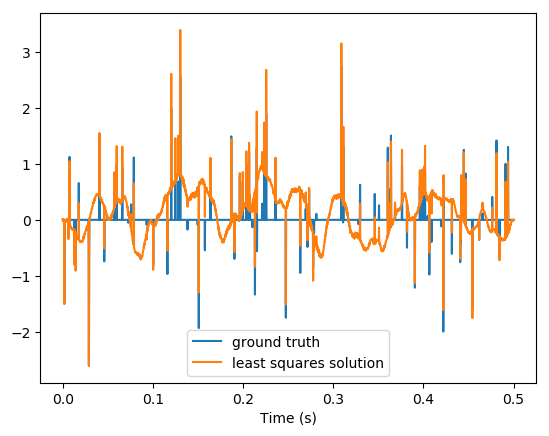

PyObject <matplotlib.legend.Legend object at 0x7fcc3ca64d50>

In [3]:
A = hcat([[zeros(i);h;zeros(Nx-1-i)] for i = 0:Nx-1]...) # Full Toeplitz Matrix

x_ls = A\y;

figure()
plot(t, x_gt, label = "ground truth")
plot(t, x_ls, label = "least squares solution")
xlabel("Time (s)")
legend()

As the figure above shows, $\mathbf{x}_{ls}$ has many artifacts. 
These are due to the fact that the matrix $\mathbf{A}$ is ill-conditioned and that the recorded signal $\mathbf{y}$ 
is corrupted by noise. 

Better results can be achieved by exploting the fact that it is known that $\mathbf{x}$ is _sparse_. 

The following optimization problem (LASSO) can be solved using `StructuredOptimization.jl`: 

$$ \mathbf{x}^{\star} =  \underset{ \mathbf{x}  }{\text{argmin}} \tfrac{1}{2} \| \mathbf{A} \mathbf{x} -\mathbf{y} \|^2 + \lambda \| \mathbf{x} \|_1  $$

where an additional term is added to promote sparsity on $\mathbf{x}$.

In [7]:
lambda = 1e-2*vecnorm(A'*y,Inf)

using StructuredOptimization

x = Variable(length(x_gt)) #define variables

@time @minimize ls(A*x-y)+lambda*norm(x,1);


    it |      gamma |        fpr |        tau |        FBE |
 ------|------------|------------|------------|------------|
     1 | 5.4370e+01 | 4.9572e-03 | 1.0000e+00 | 5.3126e-02 | 
    32 | 2.7185e+01 | 4.3131e-05 | 1.0000e+00 | 9.3630e-03 | 
  0.308770 seconds (3.44 k allocations: 3.334 MiB)


The matrix $\mathbf{A}$ represents convolution. It is actually possible to avoid its construction and use more efficient algorithms (based on `fft`). This avoids the storage of redundant information and improves the speed of the iterations of the algorithm.

In [8]:
~x .= 0. # initialized variable

@time @minimize ls(conv(x,h)-y)+lambda*norm(x,1);

    it |      gamma |        fpr |        tau |        FBE |
 ------|------------|------------|------------|------------|
     1 | 5.4370e+01 | 4.9572e-03 | 1.0000e+00 | 5.3126e-02 | 
    32 | 2.7185e+01 | 4.3131e-05 | 1.0000e+00 | 9.3630e-03 | 
  0.069708 seconds (3.45 k allocations: 3.405 MiB)


Using the sparse prior the signal can be reconstructed more accurately.

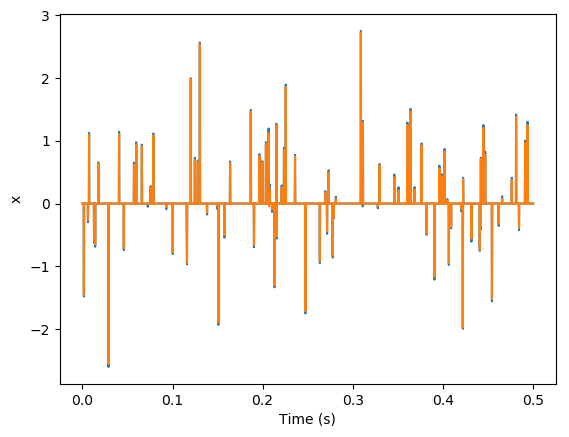

In [6]:
figure()
plot(t, x_gt, label = "ground truth")
plot(t, ~x, label = "ground truth")
xlabel("Time (s)")
ylabel("x");